In [2]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([1,1]).float()
o2 = torch.tensor([5,5]).float()
origin = [o1,o2]
radius = [2,1]
numberPoints = [nb_pts1, nb_pts2]
gd_list = mm.multipleCircles(origin, radius, numberPoints)

In [4]:
plt.scatter(gd_list[0][:, 0].detach().numpy(), gd_list[0][:, 1].detach().numpy(), c='red')
plt.scatter(gd_list[1][:, 0].detach().numpy(), gd_list[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
#plt.show()

(-1.3613887604218857,
 6.3920313523721441,
 -1.263359584052745,
 6.3805314957338002)

In [5]:
# Defining the deformation modules
sigma1 = 10
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=gd_list[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

sigma2 = 10
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=gd_list[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)

module_list = [trans1, trans2]
sigma_bg = 1
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)


In [42]:
# Setting cotangent variables
p1 = torch.cat([torch.ones(nb_pts1,1, requires_grad=True), torch.zeros(nb_pts1,1)],1).view(-1)
p2 = torch.cat([-torch.ones(nb_pts2,1,requires_grad=True), torch.zeros(nb_pts2,1)],1).view(-1)
cotan2 = [p1, p2, [p1, p2]]
cotan = [torch.ones(nb_pts1*dim, requires_grad=True), -torch.ones(nb_pts2*dim, requires_grad=True), [torch.ones((nb_pts1)*dim, requires_grad=True),-torch.ones((nb_pts2)*dim, requires_grad=True)]]
modules.manifold.fill_cotan(cotan2)



In [44]:
constr_Id = dm.constraints.Identity(modules)
l, h = modules.compute_geodesic_variables(modules.manifold, constr_Id)

In [45]:
constr_Id()

tensor([[ 9.5367e-07,  0.0000e+00],
        [-2.3842e-06,  0.0000e+00],
        [ 2.3842e-06,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 1.9073e-06,  0.0000e+00],
        [ 7.1526e-07,  0.0000e+00],
        [ 2.3842e-06,  0.0000e+00],
        [ 4.7684e-07,  0.0000e+00],
        [ 3.3379e-06,  0.0000e+00],
        [-9.5367e-07,  0.0000e+00],
        [ 3.8147e-06,  0.0000e+00],
        [ 1.7643e-05,  0.0000e+00],
        [ 6.6757e-06,  0.0000e+00],
        [ 4.7684e-06,  0.0000e+00],
        [ 7.6294e-06,  0.0000e+00],
        [ 6.6757e-06,  0.0000e+00],
        [ 2.8610e-06,  0.0000e+00]], grad_fn=<CatBackward>)

In [21]:
# Define Hamiltonian function
#H = dm.hamiltonian_multishape.Hamiltonian_multi(modules, constr_Id)

In [46]:
import defmod.hamiltonian_multishape as hamiltonian
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [ ]:
H.apply_mom()

In [ ]:
H.apply_constr()

In [ ]:
modules.cost()

In [13]:
H()

tensor(129.9349, grad_fn=<SubBackward0>)

In [11]:
# Check derivative of Hamiltonian wrt controls is zero
def controlslist2tensor(controls_list):
    return torch.cat([modules.controls[0].view(-1,1),modules.controls[1].view(-1,1), modules.controls[-1][0].view(-1,1),modules.controls[-1][1].view(-1,1)])

def controlstensor2list(controls, nb_pts, dim):
    n = sum(nb_pts)
    return [controls[:dim*nb_pts[0]], controls[dim*nb_pts[0]:dim*(nb_pts[0]+nb_pts[1])], controls[dim*n:dim*(n+nb_pts[0])], controls[dim*(n+nb_pts[0]):]]


def Hamiltonian(controls):
    #modules.controls = controlstensor2list(controls, numberPoints, dim)
    modules.fill_controls(controls)
    H = hamiltonian.Hamiltonian_multi(modules, constr_Id)
    return H()


controls = dm.usefulfunctions.flatten_tensor_list(modules.controls)


#torch.autograd.grad(Hamiltonian(modules.controls), controls)


In [47]:
manifold_t = dm.shooting.shoot_euler(H)

In [48]:
gd_t = [man.gd for man in manifold_t]


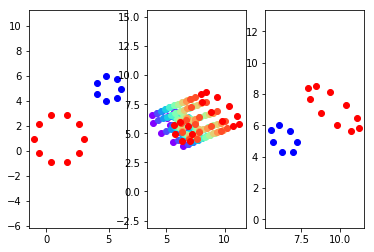

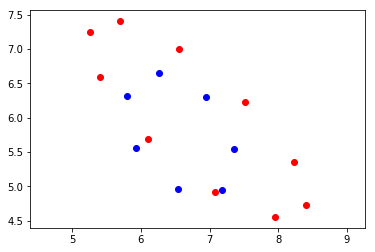

In [60]:
import matplotlib.cm as cm

source = gd_list

# Geometrical descriptors at initial time
plt.subplot(1,3,1)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

# Geometrical Descriptors transported over time by shooting
plt.subplot(1,3,2)
colors = cm.rainbow(np.linspace(0, 1, len(gd_t)))
for i,c in zip(range(len(gd_t)), colors):
    plt.scatter(gd_t[i][0].view(-1,dim)[:,0].detach().numpy(), gd_t[i][0].view(-1,dim)[:, 1].detach().numpy(), color=c)
    plt.scatter(gd_t[i][1].view(-1,dim)[:,0].detach().numpy(), gd_t[i][1].view(-1,dim)[:, 1].detach().numpy(), color=c)
plt.axis('equal')

# Geometrical descriptors at final time
plt.subplot(1,3,3)
plt.scatter(gd_t[-1][0].view(-1,dim)[:, 0].detach().numpy(), gd_t[-1][0].view(-1,dim)[:, 1].detach().numpy(), c='red')
plt.scatter(gd_t[-1][1].view(-1,dim)[:, 0].detach().numpy(), gd_t[-1][1].view(-1,dim)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')


plt.figure()
i=4
plt.scatter(gd_t[i][0].view(-1,dim)[:,0].detach().numpy(), gd_t[i][0].view(-1,dim)[:, 1].detach().numpy(), color='red')
plt.scatter(gd_t[i][1].view(-1,dim)[:,0].detach().numpy(), gd_t[i][1].view(-1,dim)[:, 1].detach().numpy(), color='blue')
plt.axis('equal')

plt.show()

In [59]:
constr_t = []
for i in range(len(manifold_t)):
    modules.compute_geodesic_variables(manifold_t[i], constr_Id)
    print(torch.norm(constr_Id()))
    constr_t = [*constr_t, constr_Id()]

constr_t[0]-constr_t[5]

tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)
tensor(2.3326e-05, grad_fn=<NormBackward0>)


tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<SubBackward0>)